In [1]:
import yfinance as yf
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

In [2]:
#Define the stoch symbol and date range
stock_symbol ='TSLA'
start_date="2020-01-01"
end_date="2023-01-01"

In [3]:
stock_data=yf.download(stock_symbol, start=start_date, end=end_date)
stock_data.to_csv("stock_data.csv")
print("Stock data saved as stock_data.csv")

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Stock data saved as stock_data.csv


In [4]:
conn=mysql.connector.connect(
    host="localhost",
    user="root",
    password="ZZaaqq1122@@",
    database="stock_prices"
)

In [5]:
#Query to fetch data
query='SELECT * FROM stock_data'

#Load data into pandas dataframe
df=pd.read_sql(query,conn)
conn.close()

print(df.head())

C:\Users\Bushra\AppData\Local\Temp\ipykernel_14372\753493866.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql(query,conn)


         date  open_price  close_price  high_price  low_price     volume
0  2020-01-02       28.30        28.68       28.71      28.11  142981500
1  2020-01-03       29.37        29.53       30.27      29.13  266677500
2  2020-01-06       29.36        30.10       30.10      29.33  151995000
3  2020-01-07       30.76        31.27       31.44      30.22  268231500
4  2020-01-08       31.58        32.81       33.23      31.22  467164500


# Data Exploration

In [6]:
#Display all columns if needed
pd.set_option('display.max_columns',None)

#Display first few rows
print('First five rows of dataset:')
display(df.head())

#Check data types and missing values
print('\nDataset Info:')
df.info()

#Check missing values
print('\nMissing Values:')
print(df.isnull().sum())

#Basic statistics
print('\nStatistical Summary:')
print(df.describe())

#Check for duplicates
duplicates=df.duplicated().sum()
print(f'\nNumber of Duplicated Rows: {duplicates}')

#Convert date column to date
if 'date' in df.columns:
    df['date']=pd.to_datetime(df['date'])


First five rows of dataset:


,date,open_price,close_price,high_price,low_price,volume
0,2020-01-02,28.30,28.68,28.71,28.11,142981500
1,2020-01-03,29.37,29.53,30.27,29.13,266677500
2,2020-01-06,29.36,30.10,30.10,29.33,151995000
3,2020-01-07,30.76,31.27,31.44,30.22,268231500
4,2020-01-08,31.58,32.81,33.23,31.22,467164500



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         756 non-null    object 
 1   open_price   756 non-null    float64
 2   close_price  756 non-null    float64
 3   high_price   756 non-null    float64
 4   low_price    756 non-null    float64
 5   volume       756 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 35.6+ KB

Missing Values:
date           0
open_price     0
close_price    0
high_price     0
low_price      0
volume         0
dtype: int64

Statistical Summary:
       open_price  close_price  high_price   low_price        volume
count  756.000000   756.000000  756.000000  756.000000  7.560000e+02
mean   206.595159   206.365556  211.409153  201.220780  1.318622e+08
std     96.049299    95.856939   98.052928   93.701408  1.001327e+08
min     24.980000    24.080000   26.990000   23.3700

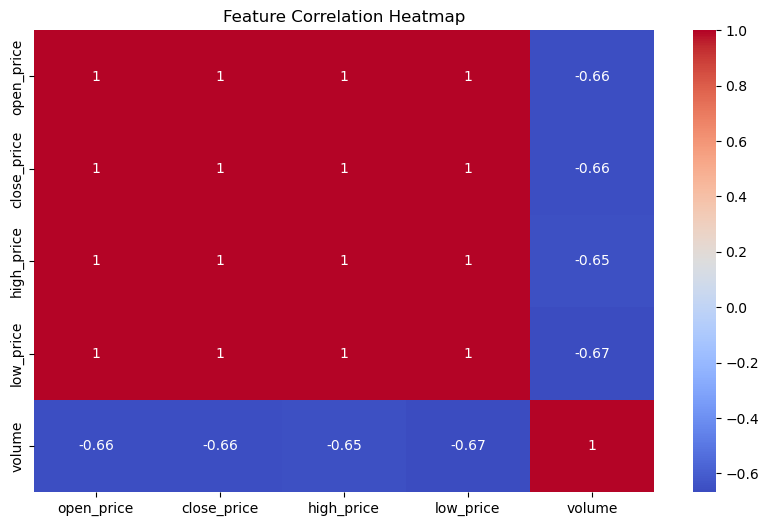

In [7]:
#Check Correlation for Numerical Values

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Feature Engineering

In [8]:
# Extract date components

df['year']=df['date'].dt.year
df['month']=df['date'].dt.month
df['day']=df['date'].dt.day
df['day_of_week']=df['date'].dt.dayofweek

In [9]:
# Lag feature (Previous day close)

df['prev_close']=df['close_price'].shift(1)

In [10]:
# Moving average (7-day, 30-day)

df['ma_7']=df['close_price'].rolling(window=7).mean()
df['ma_30']=df['close_price'].rolling(window=30).mean()

In [11]:
# Volatility (Rolling Standard deviation)

df['volatility_7']=df['close_price'].rolling(window=7).std()
df['volatility_30']=df['close_price'].rolling(window=30).std()

In [12]:
# Daily returns

df['daily_return']=df['close_price'].pct_change()

In [13]:
# Price change

df['price_change']=df['close_price'] - df['open_price']

In [14]:
# Relative strength index (RSI)

window_length=14
delta=df['close_price'].diff()
gain=(delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss=(-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
rs=gain / loss
df['RSI']=100 - (100 /(1+rs))

In [15]:
# Display first few rows after feature engineering

display(df.head())

,date,open_price,close_price,high_price,low_price,volume,year,month,day,day_of_week,prev_close,ma_7,ma_30,volatility_7,volatility_30,daily_return,price_change,RSI
0,2020-01-02,28.30,28.68,28.71,28.11,142981500,2020,1,2,3,NaN,NaN,NaN,NaN,NaN,NaN,0.38,NaN
1,2020-01-03,29.37,29.53,30.27,29.13,266677500,2020,1,3,4,28.68,NaN,NaN,NaN,NaN,0.029637,0.16,NaN
2,2020-01-06,29.36,30.10,30.10,29.33,151995000,2020,1,6,0,29.53,NaN,NaN,NaN,NaN,0.019302,0.74,NaN
3,2020-01-07,30.76,31.27,31.44,30.22,268231500,2020,1,7,1,30.10,NaN,NaN,NaN,NaN,0.038870,0.51,NaN
4,2020-01-08,31.58,32.81,33.23,31.22,467164500,2020,1,8,2,31.27,NaN,NaN,NaN,NaN,0.049248,1.23,NaN


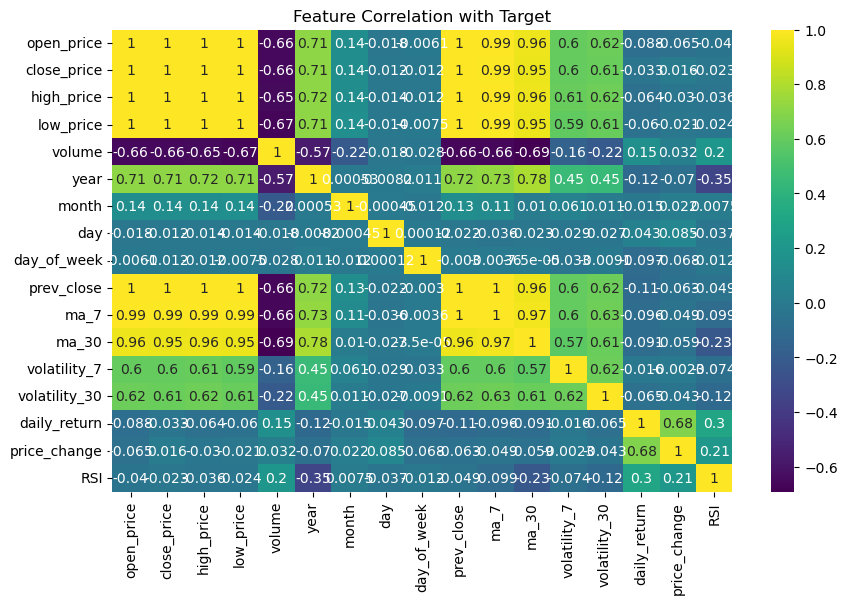

In [16]:
# Check correlation

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='viridis')
plt.title('Feature Correlation with Target')
plt.show()

In [17]:
df1=df.drop(columns=['high_price', 'low_price', 'ma_30', 'volatility_30']) # Drop highly correlated features

In [18]:
# Define features and target
X=df1.drop(columns=['date', 'close_price']) # Drop date and target variable
y=df1['close_price'] # Target variable

# Train and test split
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)

# Train RandomForest
rf= RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train,y_train)

# Get Feature importance
feature_importance= pd.DataFrame({'Feature':X.columns, 'Importance': rf.feature_importances_})
feature_importance=feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance)                                 

         Feature  Importance
0     open_price    0.690651
6     prev_close    0.270680
7           ma_7    0.033628
10  price_change    0.002347
9   daily_return    0.001297
11           RSI    0.000420
1         volume    0.000299
8   volatility_7    0.000259
4            day    0.000168
3          month    0.000127
5    day_of_week    0.000104
2           year    0.000018


In [19]:
# Keep the top 3 features

selected_features=['open_price', 'prev_close', 'ma_7']
X=df1[selected_features] # Features
y=df1['close_price']  # Target variable

# Split into train and test dataset
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (604, 3)
Testing set size: (152, 3)


# Exploratory Data Analysis

In [20]:
df1.columns

Index(['date', 'open_price', 'close_price', 'volume', 'year', 'month', 'day',
       'day_of_week', 'prev_close', 'ma_7', 'volatility_7', 'daily_return',
       'price_change', 'RSI'],
      dtype='object')

In [21]:
selected_features_all=['open_price', 'prev_close', 'ma_7', 'close_price']
dataframe=df1[selected_features_all]

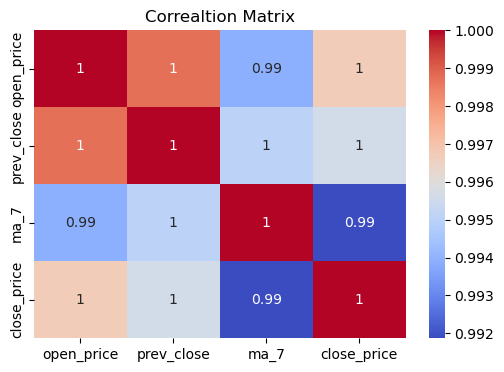

In [22]:
# Correlation heatmap

plt.figure(figsize=(6,4))
sns.heatmap(dataframe.corr(), annot=True, cmap='coolwarm')
plt.title('Correaltion Matrix')
plt.show()

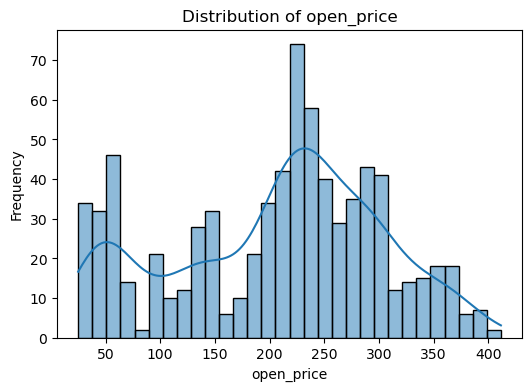

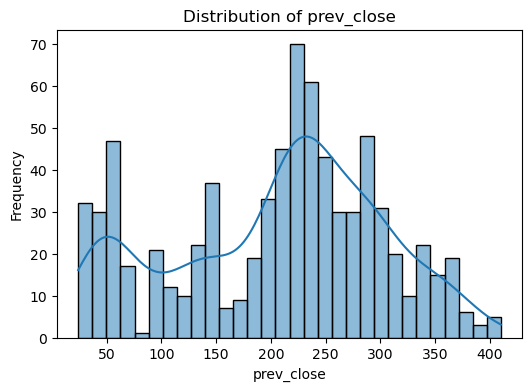

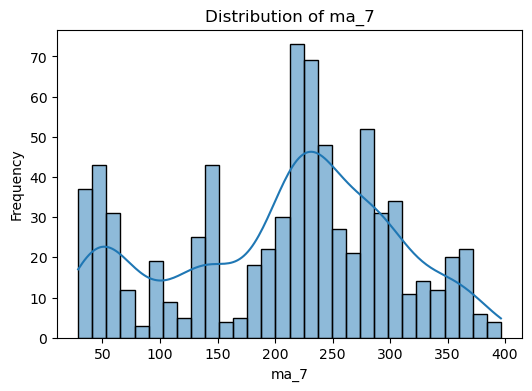

In [23]:
# Distribution of features

features=['open_price', 'prev_close', 'ma_7']
for col in features:
    plt.figure(figsize=(6,4))
    sns.histplot(dataframe[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

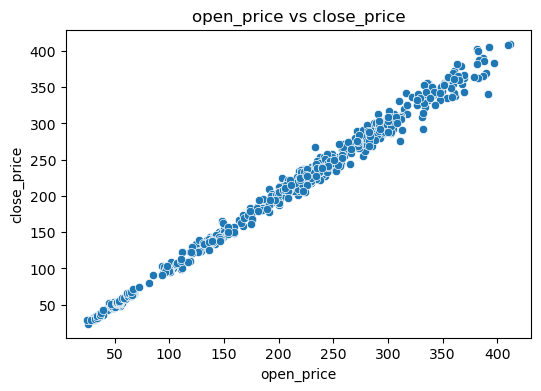

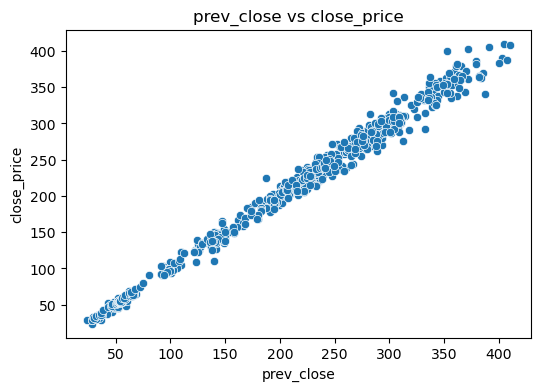

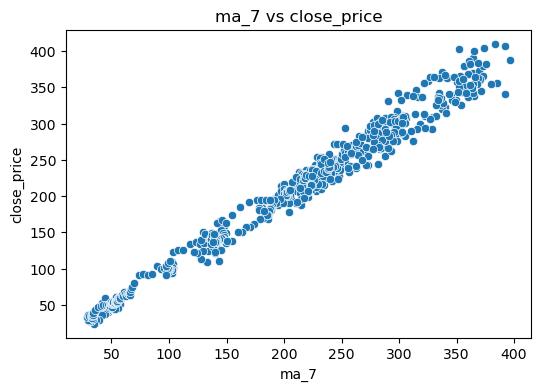

In [24]:
# Relationship between features and target

target = 'close_price'
for col in features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=dataframe[col], y=dataframe[target])
    plt.title(f"{col} vs {target}")
    plt.xlabel(col)
    plt.ylabel(target)
    plt.show()

## Observation:

“Closing price is highly correlated with previous close”
“Open price and 7-day MA have moderate correlation”
“No missing values detected”

# Baseline Model Training

In [25]:
X_train=X_train.fillna(X_train.mean())
X_test=X_test.fillna(X_test.mean())

In [26]:
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (604, 3)
Testing set size: (152, 3)


In [27]:
# Initialize and train the model

lr_model=LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression()

In [28]:
# Predict on test set

y_pred=lr_model.predict(X_test)

In [29]:
# Evaluate

mae=mean_absolute_error(y_test, y_pred)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
r2=r2_score(y_test, y_pred)

print(f"Baseline Linear Regression Model Performance ")
print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R2 : {r2:.2f}")

Baseline Linear Regression Model Performance 
MAE : 5.27
RMSE : 8.14
R2 : 0.99


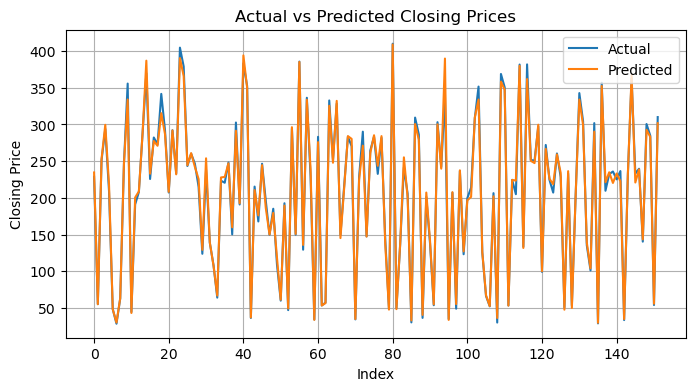

In [30]:
plt.figure(figsize=(8, 4))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted Closing Prices")
plt.xlabel("Index")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.show()

# MLflow Setup

In [31]:
# OPTIONAL: Disable autolog to avoid duplicated logging
#mlflow.sklearn.autolog(disable=True)

with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "LinearRegression-StockModel")

    # Define and train the model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Predict
    y_pred = lr_model.predict(X_test)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    # Log the model
    mlflow.sklearn.log_model(lr_model, "model")

    # Log parameter info
    mlflow.log_param("model", "LinearRegression")


2025/05/22 15:24:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


with mlflow.start_run():
    model=LinearRegression()
    model.fit(X_train,y_train)

    predictions=model.predict(X_test)

    mae=mean_absolute_error(y_test, predictions)
    rmse=mean_squared_error(y_test, predictions, squared=False)
    r2=r2_score(y_test, predictions)

    #Log parameters and metrics
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)

    #Log the trained model
    mlflow.sklearn.log_model(model, "model")

# Train and Log Additional Models Using MLFlow

## Model 2: RandomForest

In [32]:
# OPTIONAL: Turn off autolog if not already
#mlflow.sklearn.autolog(disable=True)

with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "RandomForest-StockModel")

    # Train the model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict
    y_pred = rf_model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    # Log model and parameters
    mlflow.sklearn.log_model(rf_model, "model")
    mlflow.log_param("model", "RandomForest")
    mlflow.log_param("n_estimators", 100)


2025/05/22 15:24:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Model 3: Support Vectore Regression (SVR)

In [33]:
from sklearn.svm import SVR

# Disable autolog to avoid duplication
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "SVR-StockModel")

    # Define and train the model
    svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    svr_model.fit(X_train, y_train)

    # Predict
    y_pred = svr_model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Log metrics and model
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    
    mlflow.log_param("model", "SVR")
    mlflow.log_param("kernel", "rbf")
    mlflow.log_param("C", 100)
    mlflow.log_param("gamma", 0.1)
    mlflow.log_param("epsilon", 0.1)

    mlflow.sklearn.log_model(svr_model, "model")


2025/05/22 15:24:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Model 4: XGBoost

In [34]:
import xgboost as xgb

# Disable autolog if needed
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "XGBoost-StockModel")

    # Define and train the model
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    xgb_model.fit(X_train, y_train)

    # Predict
    y_pred = xgb_model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Log metrics and parameters
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    mlflow.log_param("model", "XGBoost")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("max_depth", 3)

    # Log model
    mlflow.sklearn.log_model(xgb_model, "model")


2025/05/22 15:25:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# Code: Get Best Model by Lowest RMSE

In [35]:
# Set your experiment name
experiment_name = "Default"  

# Get experiment ID
experiment = mlflow.get_experiment_by_name(experiment_name)
experiment_id = experiment.experiment_id

# Fetch all runs in a DataFrame
runs_df = mlflow.search_runs(
    experiment_ids=experiment_id,
    filter_string="",
    order_by=["metrics.rmse ASC"],  # Lowest RMSE first
)

# Display all runs sorted by RMSE
print("All runs sorted by RMSE:")
display(runs_df[["run_id", "metrics.rmse", "params.model", "tags.mlflow.runName"]])

# Get the best run (first one with lowest RMSE)
best_run = runs_df.iloc[0]
best_run_id = best_run["run_id"]
best_model_type = best_run["params.model"]
best_rmse = best_run["metrics.rmse"]

print("\n✅ Best model based on RMSE:")
print(f"Model: {best_model_type}")
print(f"Run ID: {best_run_id}")
print(f"RMSE: {best_rmse}")


All runs sorted by RMSE:


,run_id,metrics.rmse,params.model,tags.mlflow.runName
0,f67de064a2d340b6a7e98f5ae59ae8b7,8.138363,LinearRegression,LinearRegression-StockModel
1,0905965ac2e44bb5a1269543ad79eade,8.138363,LinearRegression,LinearRegression-StockModel
2,ab4ece121d9040029005e21282df8067,8.138363,LinearRegression,LinearRegression-StockModel
3,2ca904082b4c473eb9d600042afc59ac,8.904918,RandomForest,RandomForest-StockModel
4,e97c1eed966341a28f414aba108632e6,8.904918,RandomForest,RandomForest-StockModel
5,bd4f23dddc4a490196b5e20a3c16f0b3,8.904918,RandomForest,RandomForest-StockModel
6,e4919dd96acd4287b6982f925be99194,9.700670,XGBoost,XGBoost-StockModel
7,ae8c0471eb1e444db2d7254e67db284f,9.700670,XGBoost,XGBoost-StockModel
8,67b5d8b458984dad9923f1ae5a5c2e23,9.700670,XGBoost,XGBoost-StockModel
9,3ca66d4657824d4db2a54e4a78706734,65.878359,SVR,SVR-StockModel



✅ Best model based on RMSE:
Model: LinearRegression
Run ID: f67de064a2d340b6a7e98f5ae59ae8b7
RMSE: 8.138362673096944


# Load the Best Model from MLflow

In [36]:
from mlflow.sklearn import load_model

model_uri = f"runs:/{best_run_id}/model"
best_model = load_model(model_uri)

# Use it for prediction
y_pred_best = best_model.predict(X_test)


## Save the Beast model

In [37]:
import pickle

with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)